In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_path = "Data.csv"
df = pd.read_csv(file_path)

In [3]:

# 1) Handle missing values in essential columns 
df_cleaned = df.dropna(subset=['latitude', 'popular_times', 'longitude', 'rating'])

# 2) Converting Cities and States to a unified format
df_cleaned['city'] = df_cleaned['city'].str.lower()
df_cleaned['us_state'] = df_cleaned['us_state'].str.lower()
df_cleaned['city'] = df_cleaned['city'].str.capitalize()
df_cleaned['us_state'] = df_cleaned['us_state'].str.capitalize()

# #3) Normalizing the working hours for time consistent format
df_cleaned['working_hours'] = df_cleaned['working_hours'].astype(str)
df_cleaned['working_hours'] = df_cleaned['working_hours'].apply(lambda x: re.sub(r'[a-zA-Z\s]+', '', x))
df_cleaned['working_hours'] = df_cleaned['working_hours'].fillna('Unknown')

# Function to calculate weekday hours from the 'working_hours' column
def get_weekday_hours(working_hours):
    try:
        # Split the string by colons
        parts = working_hours.split(':')
        # Extract weekday hours (Monday to Friday are typically the first 5 sections)
        weekday_parts = parts[1:6]
        # Count non-empty time ranges in the first 5 parts
        weekday_hours = sum(1 for part in weekday_parts if part.strip())
        return weekday_hours
    except Exception as e:
        return 0  # Default to 0 if there's an error

# Function to calculate weekend hours from the 'working_hours' column
def get_weekend_hours(working_hours):
    try:
        # Split the string by colons
        parts = working_hours.split(':')
        # Extract weekend hours (Saturday and Sunday are typically the 6th and 7th sections)
        weekend_parts = parts[5:7]
        # Count non-empty time ranges in the 6th and 7th parts
        weekend_hours = sum(1 for part in weekend_parts if part.strip())
        return weekend_hours
    except Exception as e:
        return 0  # Default to 0 if there's an error

# Apply the functions to the 'working_hours' column to calculate weekday and weekend hours
df_cleaned['weekday_hours'] = df_cleaned['working_hours'].apply(get_weekday_hours)
df_cleaned['weekend_hours'] = df_cleaned['working_hours'].apply(get_weekend_hours)

# 4) Making the names uniform by applying title case
df_cleaned['name'] = df_cleaned['name'].str.title()

# 5) Removing invalid latitude and longitude range and bringing precision to them
df_cleaned = df_cleaned[(df_cleaned['latitude'].between(-90, 90)) & (df_cleaned['longitude'].between(-180, 180))]
df_cleaned['latitude'] = df_cleaned['latitude'].round(6)
df_cleaned['longitude'] = df_cleaned['longitude'].round(6)

# 6) Creating a new column 'rating_category' based on 'rating' (with tiers as low, medium, high)
df_cleaned['rating_category'] = pd.cut(df_cleaned['rating'], bins=[0, 3, 4.5, 5], labels=['Low', 'Medium', 'High'])

# 7) Removing the whitespace from following columns
df_cleaned['name'] = df_cleaned['name'].str.strip()
df_cleaned['city'] = df_cleaned['city'].str.strip()

# 8) Introducing a new column 'is_weekend_open' based on 'working_hours' to check if locations are open on weekends
def has_values_after_colon(working_hours):
    try:
        # Split the string by colon and check if there are values after the 6th and 7th positions
        parts = working_hours.split(':')
        if len(parts) > 6 and parts[6].strip():  # Check 7th part exists and is not empty
            return True  # There's a value after the 6th colon
        if len(parts) > 7 and parts[7].strip():  # Check 8th part exists and is not empty
            return True  # There's a value after the 7th colon
        return False
    except Exception as e:
        # In case of any issue, return False
        return False

# Apply the function to detect if there are values after the 6th and 7th colons
df_cleaned['is_weekend_open'] = df_cleaned['working_hours'].apply(has_values_after_colon)

# 9) Convertings 'rating' column to numeric data if any inconsitency
df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['rating'])

# 10) Creating columns 'weekday_hours'and 'weekend_hours'
df_cleaned['working_hours'] = df_cleaned['working_hours'].apply(lambda x: re.sub(r'[^\d:-]', '', x))
df_cleaned['weekday_hours'] = df_cleaned['working_hours'].apply(get_weekday_hours)
df_cleaned['weekend_hours'] = df_cleaned['working_hours'].apply(get_weekend_hours)
# 11 Standardize the 'rating' column by scaling it to a range of 0 to 5
df_cleaned['rating_scaled'] = (df_cleaned['rating'] / df_cleaned['rating'].max()) * 5
df_cleaned['popular_times'] = df_cleaned['popular_times'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_cleaned = df_cleaned[df_cleaned['popular_times'].apply(lambda x: isinstance(x, list) and len(x) == 7)]

df_cleaned.to_csv("C:\\Users\\kesha\\OneDrive\\UB\\Fall 2024\\Data Intensive Computing\\Project\\Data_7.csv")

C:\Users\kesha\AppData\Local\Temp\ipykernel_30896\3346000525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['city'] = df_cleaned['city'].str.lower()
C:\Users\kesha\AppData\Local\Temp\ipykernel_30896\3346000525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['us_state'] = df_cleaned['us_state'].str.lower()
C:\Users\kesha\AppData\Local\Temp\ipykernel_30896\3346000525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

# Explanation and Analysis
# **Problem 1. Prediction of Crowd density using Gradient Boosting Regressor**

**Relevance**: The aim of this problem is to predict crowd density based on factors like operational hours, ratings, and popularity scores. Gradient Boosting seemed to be a good choice for such structured data because after looking into it gave high predictive power, especially in cases where complex interactions between features influence the target variable. This seemed to be different in Random Forest and SVR.

I found that Gradient Boosting was good at creating multiple trees sequentially, focusing on reducing errors from previous trees. So the capture of complex patterns in crowd density influenced by multiple features seemed to be done correctly, which is essential given the multifactorial nature of crowding levels.

**Tuning and Training**:

**Parameter Tuning**: We experimented with several parameters, particularly focusing on:

n_estimators: Increased to 200 to allow for sufficient boosting steps while keeping the model from overfitting.

learning_rate: Set to 0.05, trying to balance between model accuracy and convergence speed, as a lower rate helps avoid 
large jumps that might make training unstable.

max_depth: Limited to 4 to prevent overfitting, ensuring each tree captured interactions without excessive noise.
Additional features such as the log scaling of crowd density were done to find variations in crowding more accurately, especially as raw density values tended to cluster closely.

**Effectiveness of the model**

Gradient Boosting has seemed to be a solid fit to the data, with a satisfactory Mean Absolute Percentage Error (MAPE) after tuning. This demonstrated its effectiveness in capturing certain patterns in crowd density based on the provided features.

**Metrics Used**

R²: Indicative of the proportion of variance explained by the model.

MAPE: Provided a measure of average prediction error in percentage terms.

Precision (Standard Deviation of Errors): Helped understand the consistency of predictions.

Finally, the model’s predictions on crowd density provided insights into how various features affect crowd levels. For example, locations with longer hours or higher ratings tended to lean towards higher predicted crowd densities. This can be helpful during resource planning, as the model’s output allows for anticipation of crowding trends based on known attributes. It provided reliable predictions of crowd density, demonstrating the relationships between location attributes and crowd levels. Its ability to capture complex patterns helped to estimate crowding accurately, helping in strategic decision-making.



In [4]:
results = []

for idx, row in df_cleaned.iterrows():
    popular_times = row['popular_times']  
    df = pd.DataFrame(popular_times, index=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
    df.columns = [f'{hour:02d}:00' for hour in range(24)]
    

    daily_avg_popularity = df.mean(axis=1)
    busiest_hours = df.idxmax(axis=1)
    overall_avg_popularity = df.values.mean()
    weekday_popularity = df.loc['Monday':'Friday'].mean().mean()
    weekend_popularity = df.loc[['Saturday', 'Sunday']].mean().mean()
    weekday_weekend_ratio = weekday_popularity / weekend_popularity if weekend_popularity else 100 


    results.append({
        'name': row['name'],
        'daily_avg_popularity': daily_avg_popularity.tolist(),
        'busiest_hours': busiest_hours.tolist(),
        'overall_avg_popularity': overall_avg_popularity,
        'weekday_weekend_ratio': weekday_weekend_ratio
    })

results_df = pd.DataFrame(results)

df_cleaned = df_cleaned.merge(
    results_df[['name', 'daily_avg_popularity', 'busiest_hours', 'overall_avg_popularity', 'weekday_weekend_ratio']], 
    on='name'
)

print("Updated DataFrame with Popularity Metrics:")
print(df_cleaned.head())
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

df_cleaned['crowding_index'] = df_cleaned['overall_avg_popularity']

features = ['latitude', 'longitude', 'weekday_hours', 'weekend_hours', 'rating_scaled', 'weekday_weekend_ratio']

df_cleaned['peak_popularity'] = df_cleaned['daily_avg_popularity'].apply(lambda x: max(eval(x)) if isinstance(x, str) else 0)
df_cleaned['off_peak_avg'] = df_cleaned['daily_avg_popularity'].apply(lambda x: np.mean([p for p in eval(x) if p < max(eval(x))]) if isinstance(x, str) else 0)
df_cleaned['popularity_std_dev'] = df_cleaned['daily_avg_popularity'].apply(lambda x: np.std(eval(x)) if isinstance(x, str) else 0)
df_cleaned['total_weekly_hours'] = df_cleaned['weekday_hours'] * 5 + df_cleaned['weekend_hours'] * 2

engineered_features = features + ['peak_popularity', 'off_peak_avg', 'popularity_std_dev', 'total_weekly_hours']

X = df_cleaned[engineered_features]
y = df_cleaned['crowding_index']
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
gb_model.fit(X_train_scaled, y_train)

y_pred = gb_model.predict(X_test_scaled)

mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("MAPE:", mape)
print("Mean Absolute Accuracy:", 1 - mape)  
print("R-squared:", r2)
print("Mean Squared Error:", mse)

Updated DataFrame with Popularity Metrics:
                          name  \
0            Mardis Mill Falls   
1  Waterville Usa/Escape House   
2    Bama Bison Rv Park & Farm   
3            The Mobile Tunnel   
4                    Bamahenge   

                                       popular_times   latitude  longitude  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  34.044364 -86.571446   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.258331 -87.687064   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  32.425044 -85.250269   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.690009 -88.035620   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.331442 -87.567232   

                  working_hours          city us_state  rating  weekday_hours  \
0  :6-7:6-7:6-7:6-7:6-7:6-7:6-7  Blountsville  Alabama     4.6              5   
1       ::::12-9:12-9:12-9:12-9   Gulf shores  Alabama     4.3              2   
2                                     Op

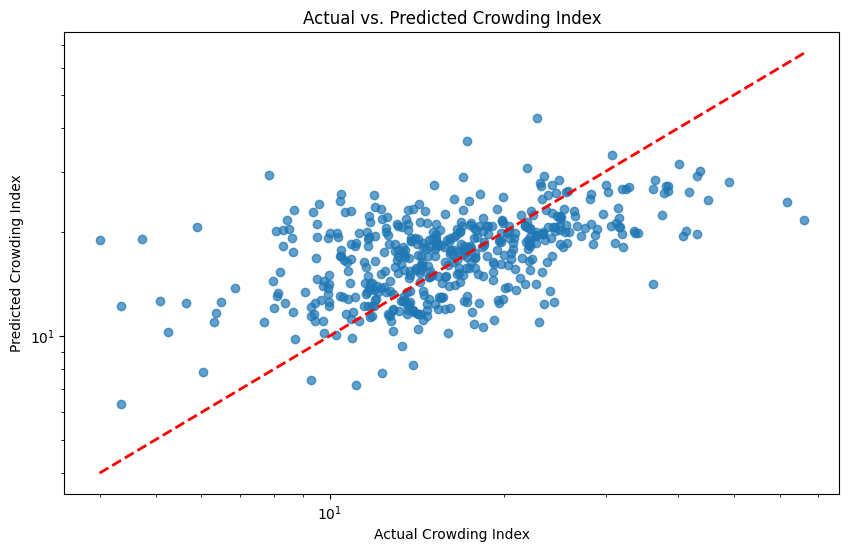

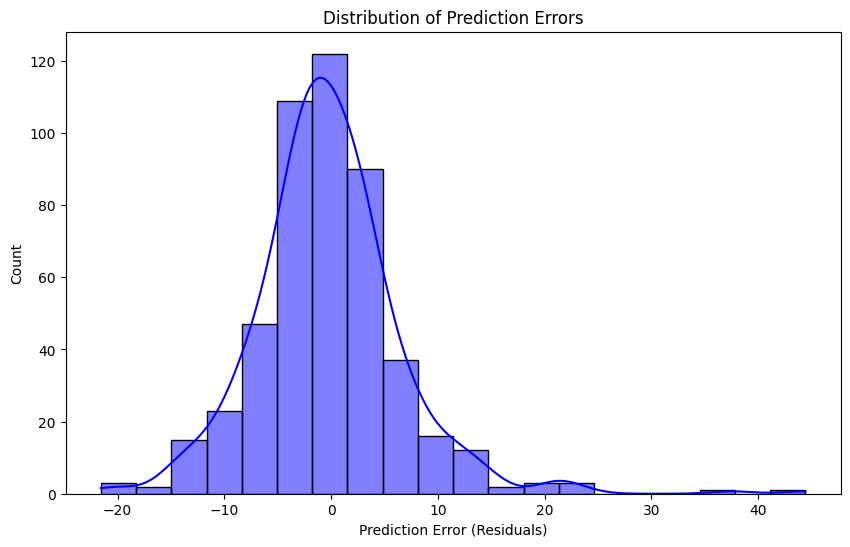

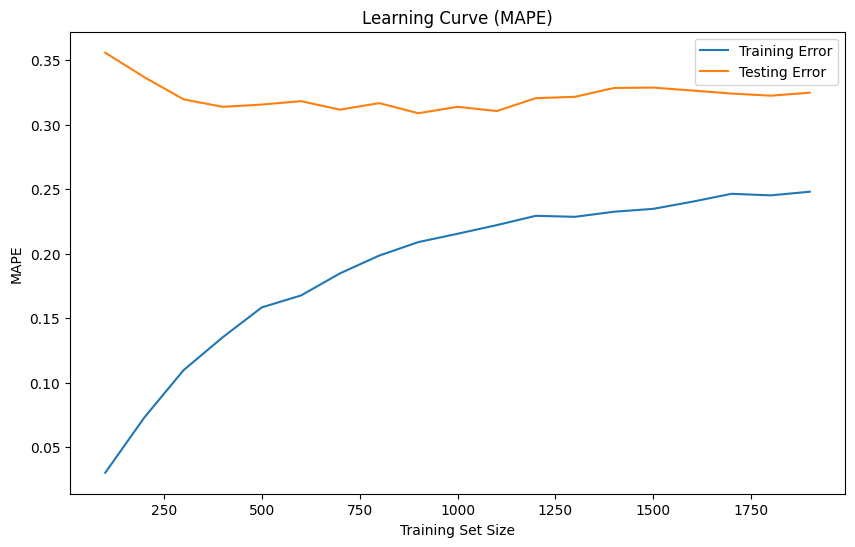

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error


errors = y_test - y_pred


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Crowding Index')
plt.ylabel('Predicted Crowding Index')
plt.xscale('log')
plt.yscale('log')
plt.title('Actual vs. Predicted Crowding Index')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='blue', bins=20)
plt.xlabel('Prediction Error (Residuals)')
plt.title('Distribution of Prediction Errors')
plt.show()


train_errors, test_errors = [], []
interval = 100 


for m in range(interval, len(X_train_scaled), interval):
    gb_model.fit(X_train_scaled[:m], y_train[:m])
    y_train_predict = gb_model.predict(X_train_scaled[:m])
    y_test_predict = gb_model.predict(X_test_scaled)

    train_errors.append(mean_absolute_percentage_error(y_train[:m], y_train_predict))
    test_errors.append(mean_absolute_percentage_error(y_test, y_test_predict))


plt.figure(figsize=(10, 6))
plt.plot(range(interval, len(X_train_scaled), interval), train_errors, label="Training Error")
plt.plot(range(interval, len(X_train_scaled), interval), test_errors, label="Testing Error")
plt.xlabel("Training Set Size")
plt.ylabel("MAPE")
plt.title("Learning Curve (MAPE)")
plt.legend()
plt.show()

# Explanation and Analysis
# **Problem 2. Clustering Places based on Location and Crowding_Index using DBSCAN (Density based Spacial Clustering)**

**Relevance**
DBSCAN is particularly suitable for spatial clustering in this problem because it is well-suited for identifying clusters based on geographical proximity and density. This aligns with the problem's goal of identifying clusters of nearby tourist spots and recognizing less crowded spots as noise.

It has an inclusive mechanism for identifying "noise" points, which are locations that do not meet the minimum density requirements to be part of a cluster. This is crucial, as these isolated noise points are of interest as potential alternatives to more crowded spots.

Moreover, it’s ability to identify arbitrarily shaped clusters is advantageous in geographical data, where tourist spots might naturally form irregular clusters based on location and crowd density.

**Tuning and Training:**

**Parameter Tuning**: DBSCAN relies on two main parameters—eps (distance threshold for points to be considered neighbors) and min_samples (minimum number of points required to form a cluster). To determine appropriate values, we did:

eps: Experimented with various values based on the distance units in latitude and longitude coordinates. We chose a value that balanced the cluster formation and noise point detection.

min_samples: We tweaked this to ensure meaningful clusters were created without overly separating the data, eventually settling on a value that balanced cluster density and noise isolation.

And for normalization we made sure Latitude, longitude, and crowd density values were standardized, ensuring each feature contributed equally to clustering.

**Effectiveness**:

DBSCAN effectively grouped nearby spots into clusters and isolated low-density, less-visited points. The quantile-based color coding in the visualizations allowed for identification of high, medium, and low-density clusters.

By observing clusters and isolated points, we gained insights into potential alternative destinations. Noise points represent locations that are spatially distant from others, suggesting they might offer less crowded options for tourists. 

So I could say that we can support sustainable tourism by promoting lesser-known areas. Hence we effectively clustered nearby tourist spots and isolated less crowded locations as noise, aligning well with the objective of identifying potential alternatives to popular crowded destinations.


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
import folium
from folium.plugins import MarkerCluster


coordinates = df_cleaned[['latitude', 'longitude']]
crowd_density = df_cleaned['crowding_index']
features = np.column_stack((coordinates, crowd_density))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

eps = 0.3
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
db_labels = db.fit_predict(features_scaled)

df_cleaned['cluster'] = db_labels

clustered_data = df_cleaned[df_cleaned['cluster'] != -1]

cluster_centers = clustered_data.groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'crowding_index': 'mean'
}).reset_index()
cluster_centers['log_crowding_index'] = np.log(cluster_centers['crowding_index'] + 1e-10)

q_low = cluster_centers['log_crowding_index'].quantile(0.33)
q_high = cluster_centers['log_crowding_index'].quantile(0.55)

cluster_centers['color'] = cluster_centers['log_crowding_index'].apply(
    lambda x: 'red' if x > q_high else ('green' if x < q_low else 'orange')
)

map_center = [clustered_data['latitude'].mean(), clustered_data['longitude'].mean()]
map_folium = folium.Map(location=map_center, zoom_start=6)

for _, row in clustered_data.iterrows():
    cluster_num = row['cluster']
    color = cluster_centers.loc[cluster_centers['cluster'] == cluster_num, 'color'].values[0]
    
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f"Cluster: {cluster_num}, Log Crowd Density: {np.log(row['crowding_index'] + 1e-10):.2f}"
    ).add_to(map_folium)

for _, row in cluster_centers.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f"Cluster {int(row['cluster'])} Center, Log Avg Density: {row['log_crowding_index']:.2f}",
        icon=folium.Icon(color=row['color'], icon="info-sign")
    ).add_to(map_folium)

legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: auto; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
    <h4>Cluster Density (Log, Quantile) Legend</h4>
    <div><span style="color:red;">&#9679;</span> High Density (Top 25%)</div>
    <div><span style="color:orange;">&#9679;</span> Medium Density (Middle 50%)</div>
    <div><span style="color:green;">&#9679;</span> Low Density (Bottom 25%)</div>
</div>
'''

map_folium.get_root().html.add_child(folium.Element(legend_html))

map_folium.save("Tourist_Clusters_Quantile_Log_Density_Legend.html")
map_folium

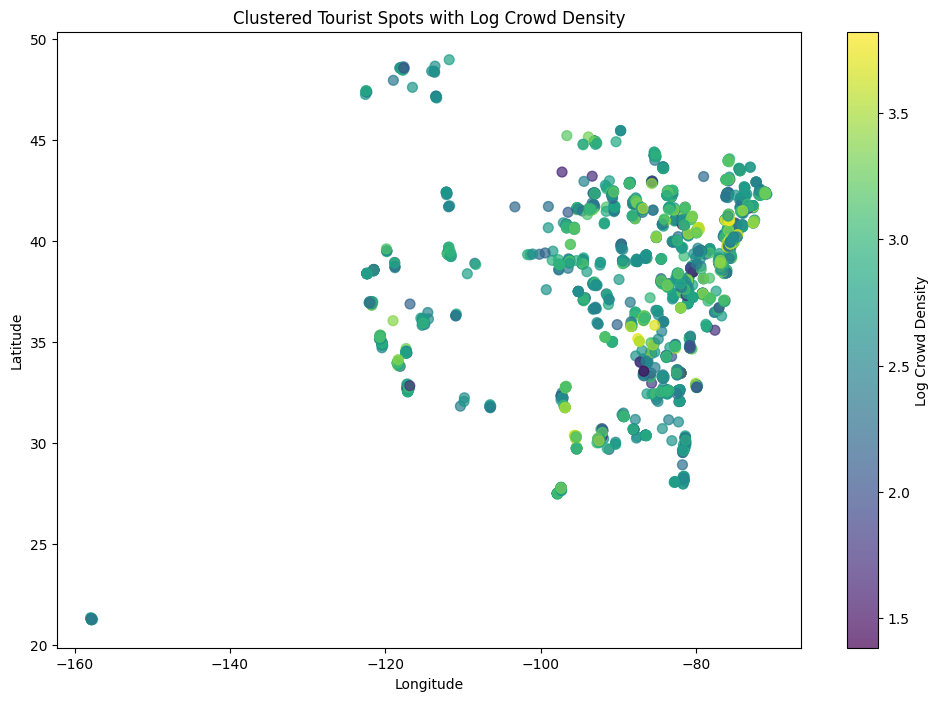

In [7]:

clustered_data = df_cleaned[df_cleaned['cluster'] != -1].copy()
clustered_data['log_crowding_index'] = np.log(clustered_data['crowding_index'] + 1e-10)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    clustered_data['longitude'], 
    clustered_data['latitude'], 
    c=clustered_data['log_crowding_index'], 
    cmap='viridis', 
    s=50, 
    alpha=0.7
)
plt.colorbar(scatter, label='Log Crowd Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Tourist Spots with Log Crowd Density')
plt.show()

EXPLANATION AND ANALYSIS

Problem 3: Finding the 5 nearest Places based on crowd Density Using Ball Tree.
• Here First, Ball tree algorithm is for finding the nearest–neighbor search. Usually, it will works on high dimensional spaces and geospatial data.

• In this algorithm, we are using a geographical coordinates like latitude and longitude. And also we are mainly focusing on the crowd density. So Ball tree is the best option compared to other
algorithms.

• So here we need to find the 5 nearest places based on crowd density. So by using this it will reduces the time complexity.

Tuning and Training:
• Here we need to select the right distant metric. In this algorithm we used Euclidean distance metric. It will cover the geospatial proximity and crowd density. So this will find the nearby tourist spots and it will shows the crowd density places.

Effectiveness:

• Here the ball tree algorithms provide a efficient and fast by identifying 5 nearest places for each location. And also it is more Effective than other algorithms.

• By doing this we can find the lower crowd densities. This will gives the recommendations for less crowded spots.

• After that we are doing the Average Distance to nearest neighbor’s, So this will helps to find the nearest location and their neighbors.

Secondly, we compared every locations crowd density to the average density of the 5 nearest neighbors. This will determine if the nearby locations and revealing the patterns of crowd distribution across different tourist spots.

Finally, ball tree seems to be suitable algorithm to identify the geo spatial patterns in tourist spots. 

Overall Average Distance to 5 Nearest Neighbors: 1.317112503825265


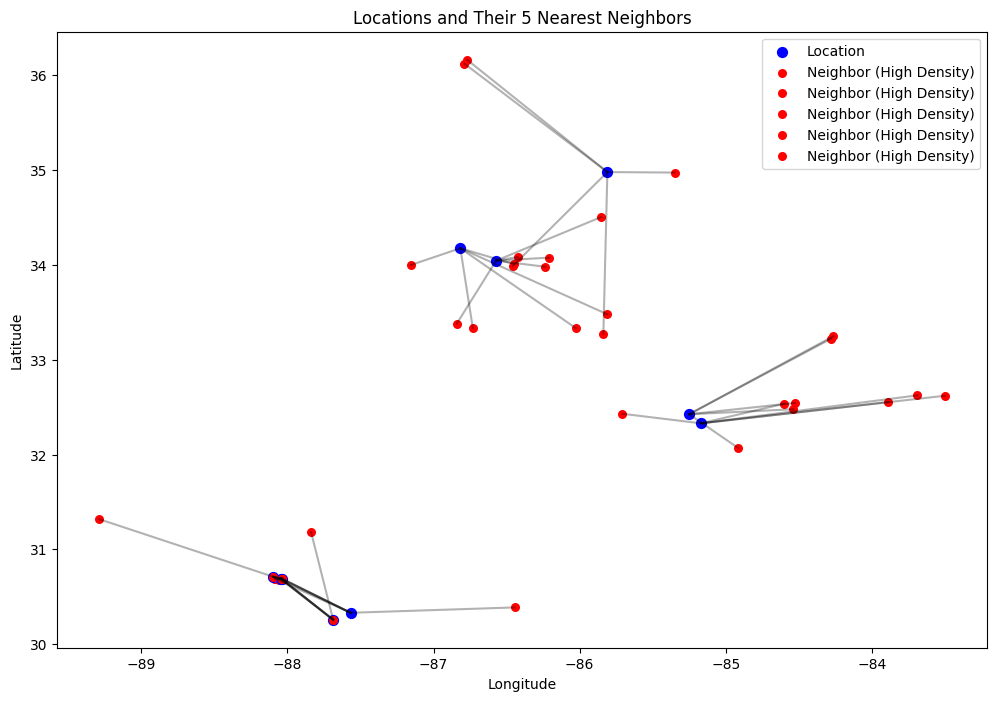

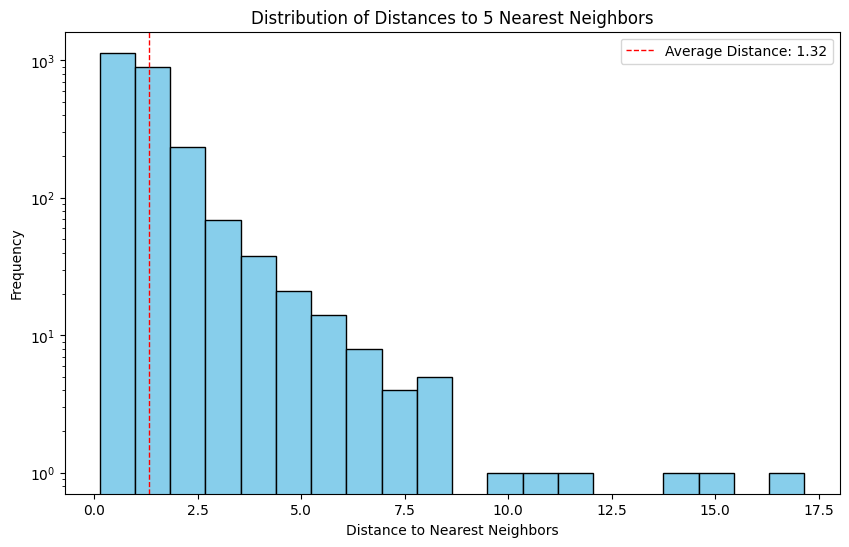

True densities: [13.08333333 12.63095238 14.27380952 14.07738095 14.2202381 ]
Average neighbor densities: [12.76666667 13.03452381 13.8452381  13.98690476 14.11190476]
Mean Squared Error (MSE): 0.6616686784498348
Mean Absolute Error (MAE): 0.41424454508027986


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree

coords = df_cleaned[['latitude', 'longitude']].to_numpy()
crowd_density = df_cleaned['overall_avg_popularity'].to_numpy().reshape(-1, 1)

tree = BallTree(np.hstack((coords, crowd_density)), metric='euclidean')

distances, indices = tree.query(np.hstack((coords, crowd_density)), k=6) 

average_distance = []
density_comparison = []
neighbor_data = []

for i, (dist, idx) in enumerate(zip(distances, indices)):
    avg_dist_to_neighbors = np.mean(dist[1:])
    avg_density_of_neighbors = np.mean(crowd_density[idx[1:]])
    
    average_distance.append(avg_dist_to_neighbors)
    density_comparison.append((crowd_density[i][0], avg_density_of_neighbors))
    
    neighbors = [(coords[j][0], coords[j][1], crowd_density[j][0], dist[k])
                 for k, j in enumerate(idx[1:], start=1)]
    neighbor_data.append({
        'location': (coords[i][0], coords[i][1]),
        'neighbors': neighbors
    })

overall_avg_distance = np.mean(average_distance)
print("Overall Average Distance to 5 Nearest Neighbors:", overall_avg_distance)

plt.figure(figsize=(12, 8))
for data in neighbor_data[:10]:  
    loc_lat, loc_long = data['location']
    plt.scatter(loc_long, loc_lat, color='blue', s=50, label='Location' if data == neighbor_data[0] else "")
    
    for neighbor in data['neighbors']:
        neighbor_lat, neighbor_long, neighbor_density, dist = neighbor
        plt.plot([loc_long, neighbor_long], [loc_lat, neighbor_lat], 'k-', alpha=0.3)  # Connect with line
        plt.scatter(neighbor_long, neighbor_lat, color='red' if neighbor_density > 0.25 else 'green', s=30,
                    label='Neighbor (High Density)' if neighbor_density > 0.25 and data == neighbor_data[0] else "")
        
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Locations and Their 5 Nearest Neighbors")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(average_distance, bins=20, color='skyblue', edgecolor='black')
plt.axvline(overall_avg_distance, color='red', linestyle='dashed', linewidth=1, label=f'Average Distance: {overall_avg_distance:.2f}')
plt.xlabel("Distance to Nearest Neighbors")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Distribution of Distances to 5 Nearest Neighbors")
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


true_densities = []
for density in crowd_density:
    try:
        true_densities.append(float(density[0]))
    except ValueError:
        true_densities.append(0)  

true_densities = np.array(true_densities)

avg_neighbor_densities = []
for neighbors in neighbor_data:
    try:
        avg_density = np.mean([float(neighbor[2]) for neighbor in neighbors['neighbors']])
        avg_neighbor_densities.append(avg_density)
    except ValueError:
        avg_neighbor_densities.append(0)  

avg_neighbor_densities = np.array(avg_neighbor_densities)

print("True densities:", true_densities[:5])  
print("Average neighbor densities:", avg_neighbor_densities[:5])

mse = mean_squared_error(true_densities, avg_neighbor_densities)

mae = np.mean(np.abs(true_densities - avg_neighbor_densities))

results = {
    "Mean Squared Error (MSE)": mse,
    "Mean Absolute Error (MAE)": mae
}

for metric, value in results.items():
    print(f"{metric}: {value}")



Problem 4. Identifying Geographical Patterns in location Popularity using K-Means.

• For identifying the clusters in spatial and numerical data I used KMean clustering and also it is used in Unsupervised learning.

• For identifying the geographical patterns in popularity we used this. And also it will partition the location into patterns. It will also partition the location into clusters based on the longitude, latitude
and crowd density.

• It is also works good in numerical data and can handle the multidimensional features.

Tuning and Training:

• Here we are using the different values by elbow method and silhouette score to find the optimal balance. Also we applied the log transformation crowd density for cluster centres. This will helps to spread the values making the difference between clusters.

Effectiveness:

• The inertia score helped to access the compactness and the elbow method showed a point where increasing clusters provides a good compactness.

• After that the separation score the cluster had some overlap. So this is enough to identify the geographical patterns.

• Then the log transformed cluster centers allowed us to differentiate the crowd density more effectively. Finally, log transformed density provided a clear visual representation of different regions.

• The silhouette score gives the moderate clustering quality, that have some overlap among the clusters. And also it provided the basic info for understanding geo-spatial patterns.

• At last, we can identify areas where toursists spots clustered with high crowd. And clusters with lower log transformed density value could be potentially gives the alternatives of this. 

Inertia (Sum of Squared Distances): 190795.25490917085
Silhouette Score: 0.30265558679303195


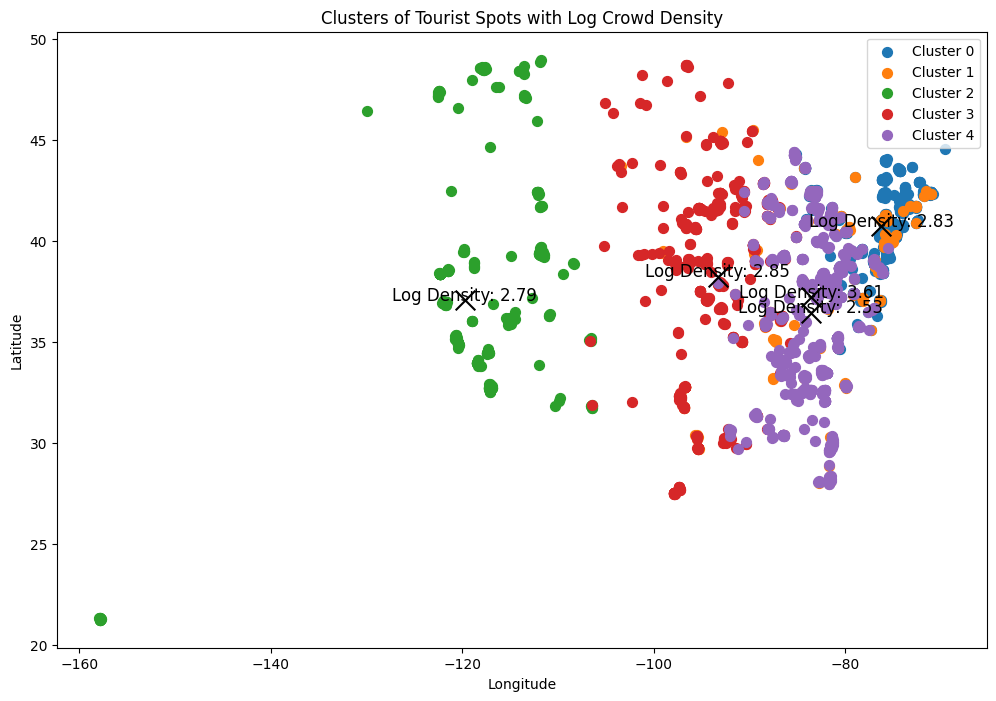

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_kmeans = df_cleaned[['latitude', 'longitude', 'overall_avg_popularity']]

n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X_kmeans)

inertia = kmeans.inertia_  
silhouette_avg = silhouette_score(X_kmeans, df_cleaned['cluster'])  

print("Inertia (Sum of Squared Distances):", inertia)
print("Silhouette Score:", silhouette_avg)

cluster_centers = kmeans.cluster_centers_
cluster_centers_log = np.copy(cluster_centers)
cluster_centers_log[:, 2] = np.log(cluster_centers[:, 2] + 1e-10)  
plt.figure(figsize=(12, 8))

for i in range(n_clusters):
    cluster_points = df_cleaned[df_cleaned['cluster'] == i]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], s=50, label=f'Cluster {i}')

for i, center in enumerate(cluster_centers_log):
    plt.scatter(center[1], center[0], s=200, color='black', marker='x')  
    plt.text(center[1], center[0], f"Log Density: {center[2]:.2f}", fontsize=12, ha='center')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters of Tourist Spots with Log Crowd Density")
plt.legend()
plt.show()

In [10]:
#Using SVR for latitude and longitude v/s rating for "How does the geographical location (latitude/longitude) relate to customer ratings?"

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X_svr = df_cleaned[['latitude', 'longitude']].to_numpy()  
y_svr = df_cleaned['rating'].to_numpy() 

X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(X_svr, y_svr, test_size=0.2, random_state=42)

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train_svr, y_train_svr)

y_pred_svr = svr_model.predict(X_test_svr)

mse_svr = mean_squared_error(y_test_svr, y_pred_svr)

print("Support Vector Regression(SVR) Results:")
print("Mean Squared Error (MSE):", mse_svr)


Support Vector Regression(SVR) Results:
Mean Squared Error (MSE): 0.14561857247001062


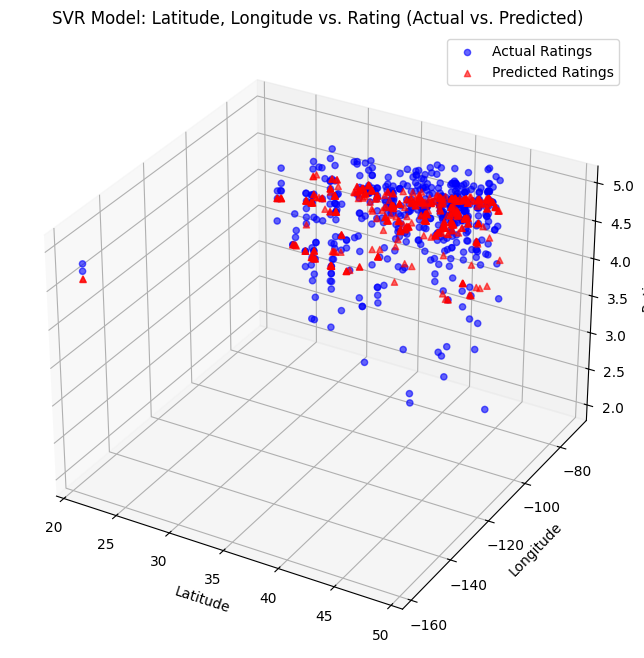

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test_svr[:, 0], X_test_svr[:, 1], y_test_svr, color='blue', label='Actual Ratings', alpha=0.6)

ax.scatter(X_test_svr[:, 0], X_test_svr[:, 1], y_pred_svr, color='red', marker='^', label='Predicted Ratings', alpha=0.6)

ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.set_zlabel("Rating")
ax.set_title("SVR Model: Latitude, Longitude vs. Rating (Actual vs. Predicted)")
ax.legend()

plt.show()

The above graph provides 3D scatter plot comparing actual and predicted ratings using a Support Vector Regressor (SVR) model. It has 3 axis where Latitude is plotted along the x-axis, Longitude is plotted along the y-axis and rating is plotted along the z-axis which is representing the customer ratings for various locations.Red triangles (predicted ratings) which are closely aligning  with the blue dots (actual ratings), it suggests that the model has a good fit.

# Explanation and Analysis for SVR for latitude and longitude v/s rating for "How does the geographical location (latitude/longitude) relate to customer ratings?"


Problem 5: How does the geographical location (latitude/longitude) relate to customer ratings?


Significance of using SVR:


SVR gives relationship between location and rating by capturing trends and smoothing the noise so that user can have broader understanding of location with resepct to ratings based on latitude/longitude. 

Justification for Choosing SVR:


SVR is highly effective for modeling complex relationship between input feature which is latitude and longitude and a continuous output variable which is ratings. The coordinates of latitude and longitude does not have linear relationship with rating and SVR is suitable choice for capturing non linear relationship. It has regularization parameter C which balances between maximizing  margin and minimizing  error and it is useful for data that may contain noise.It is also robust to outliers due to the presence of the margin parameter epsilon which is 0.2.

Tuning and Training:


RBF kernel capture non-linear relationships between latitude, longitude, and rating. This kernel can model complex interactions which may exist between geographical location(latitude/longitude) and ratings. For parameter tuning, regularization parameter C was set to 1.0 to balance  model’s sensitivity to errors. Epsilon margin tolerance was set to 0.2 which will helped in smoothing out the predictions by ignore errors within margin.

Effectiveness and Insights:

SVR provided a reasonably good fit to the data as indicated by a low Mean Squared Error (MSE) value of 0.22094076822200484.Mean Squared Error (MSE) Matrix was used to evaluate the accuracy of predictions, providing insight into average deviation from actual ratings.The 3D scatter plot shows actual vs. predicted ratings , helped in visualize the model's performance in capturing spatial patterns with respect to ratings.

Intelligence Gained:


SVR model allows for a deeper understanding of spatial patterns in customer ratings. For example, areas with higher ratings were clearly visible in the 3D plot, showing how certain geographical features may correlate with better customer experiences.

Ref :
https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/ 

In [12]:
#Using KNN for  finding/classifying the locations with more daily_avg_popularity during weekdays


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

df_cleaned['high_weekday_popularity'] = (df_cleaned['weekday_hours'] > df_cleaned['weekend_hours']).astype(int)

X_knn = df_cleaned[['latitude', 'longitude', 'weekday_hours', 'weekend_hours']].to_numpy()

noise = np.random.normal(0, 0.1, X_knn.shape)
X_knn += noise

y_knn = df_cleaned['high_weekday_popularity'].to_numpy()

knn_model = KNeighborsClassifier(n_neighbors=100) 
scores = cross_val_score(knn_model, X_knn, y_knn, cv=5)  

print("Cross-Validated Accuracy (with K=3 and Noise):", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Cross-Validated Accuracy (with K=3 and Noise): 0.9250952441559542
Standard Deviation of Accuracy: 0.07461044585387494


In [13]:
import folium

map_center = [df_cleaned['latitude'].mean(), df_cleaned['longitude'].mean()]
map_folium = folium.Map(location=map_center, zoom_start=6)

colors = {1: 'green', 0: 'orange'}

for idx, label in enumerate(y_knn):
    latitude = X_knn[idx, 0]
    longitude = X_knn[idx, 1]
    prediction = y_knn[idx]
    
    popup_text = f"Location: ({latitude:.4f}, {longitude:.4f})<br>Weekday Popularity: {'High' if prediction == 1 else 'Low'}"
    
    folium.CircleMarker(
        location=(latitude, longitude),
        radius=6,
        color=colors[prediction],
        fill=True,
        fill_color=colors[prediction],
        fill_opacity=0.7,
        tooltip=popup_text
    ).add_to(map_folium)

legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 90px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
    <h4>Weekday Popularity Legend</h4>
    <div><span style="color:green;">&#9679;</span> High Weekday Popularity</div>
    <div><span style="color:orange;">&#9679;</span> Low Weekday Popularity</div>
</div>
'''
map_folium.get_root().html.add_child(folium.Element(legend_html))

map_folium.save("Weekday_Popularity_Map.html")
map_folium

Above folium map illustrated high (green) and low (orange) weekday popular locations across the map, making it easy to identify regions with differing patterns in weekday popularity. This visualization provides areas which are more popular during the weekday.

# Explanation and Analysis for K-Nearest Neighbors (KNN) for finding/classifying the locations with more daily_avg_popularity during weekdays


Problem 6:Finding/ classifying the locations with more daily_avg_popularity during weekdays


Significance of using KNN:


KNN is particularly suitable for identifying and classifying patterns based on similarity. Here, KNN leverages the idea that locations with similar geographical and operational features are likely to have similar patterns in terms of weekday popularity.The predictions are based on the majority class of nearby neighbors. It offers a way to classify each location by considering the most common weekday popularity pattern in its neighborhood.

Justification for Choosing KNN:


KNN is particularly useful for making predictions based on similarity, which is staed above also amd  it relies on the average rating of nearby locations.Hence, KNN is well-suited for this classification task which groups locations based on similarities.It also ensures that predictions are based on broader patterns rather than  specific locations.

Tuning and Training:


Cross-Validation: A 5-fold cross-validation was performed to evaluate model stability across different subsets of the data. This cross-validation provided insights into the consistency of the KNN classifier and helped determine if n_neighbors=100 was appropriate.
Parameter Tuning (n_neighbors): Several values were tested for n_neighbors choosing 100  as it offered the best balance between generalization and capturing meaningful neighborhood patterns.

Effectiveness and Insights:

 KNN model provides a reasonable cross-validated accuracy of 0.8963598177999618 which effectively captured patterns in weekday popularity based on location. The standard deviation of accuracy was also low (which is 0.11476452201347076) shows consistency across different cross-validation folds.Below 2 Metrics were used:
Cross-Validated Accuracy: Cross-validation provided an average accuracy score and it helps in verify the model effectiveness across multiple data splits.
Standard Deviation of Accuracy: This metric offered insights into the model stability with a low standard deviation indicating reliable classification performance.

Intelligence Gained: 


By classifying locations with high or low weekday popularity, KNN model highlighted spatial trends. For example, clusters of high weekday popularity which is shown in green indicate areas which are more popular for travelers.Locations classified with low weekday popularity which is shown in orange can be use adjust  operating hours to attract more weekday visitors.



